In [1]:
import os, sys

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from sklearn.utils.extmath import row_norms
from sklearn.metrics.pairwise import _euclidean_distances


project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

from yace.run_worker import JobInfo

In [2]:
def get_performance_results(working_dir):
    distortions_rand = pd.read_feather(working_dir/"distortions-random-solutions.feather")
    distortions_conv = pd.read_feather(working_dir/"distortions-convex-solutions.feather")
    
    df1 = distortions_rand.agg(
        rand_distortion_mean=("distortion", np.mean),
        rand_distortion_std=("distortion", np.std),
        rand_distortion_min=("distortion", np.min),
        rand_distortion_max=("distortion", np.max),
    )

    df2 = distortions_conv.agg(
        conv_distortion_mean=("distortion", np.mean),
        conv_distortion_std=("distortion", np.std),
        conv_distortion_min=("distortion", np.min),
        conv_distortion_max=("distortion", np.max),
    )

    performance_results = pd.concat([df1, df2]).T.to_dict(orient="records")[0]
    return performance_results

def get_results(file_paths):
    raw_data = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = Path(f"../{job_info.working_dir}")
        perf_results = get_performance_results(working_dir=working_dir)
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        raw_data.append({
            "k": job_info.experiment_params["k"],
            "epsilon": job_info.experiment_params["epsilon"],
            "algorithm": job_info.experiment_params["algorithm_name"],
            "running_time": duration_secs,
            **perf_results,
        })
    df_data = pd.DataFrame(raw_data)
    return df_data

def get_raw_results(file_paths):
    data_frames = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = Path(f"../{job_info.working_dir}")
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        
        
        df_perf_data = pd.concat([
            pd.read_feather(working_dir/"distortions-random-solutions.feather"),
            pd.read_feather(working_dir/"distortions-convex-solutions.feather")
        ])
        df_perf_data["experiment_id"] = working_dir.name
        df_perf_data["experiment_type"] = experiment_type
        df_perf_data["k"] = job_info.experiment_params["k"]
        df_perf_data["epsilon"] = job_info.experiment_params["epsilon"]
        df_perf_data["algorithm"] = job_info.experiment_params["algorithm_name"]
        df_perf_data["running_time_secs"] = duration_secs
        data_frames.append(df_perf_data)
    df_data = pd.concat(data_frames)
    return df_data

def add_combined_mean_std(df: pd.DataFrame, attr: str):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.4f} ({std:0.5f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)


In [3]:
data_results_dir = Path("../data/experiments/simple/ss_us_01/")

In [4]:
job_info_paths = list(data_results_dir.glob("**/job-info.json"))

In [5]:
job_info_paths

[PosixPath('../data/experiments/simple/ss_us_01/2022-05-12-11-00-16-297141-074987/job-info.json'),
 PosixPath('../data/experiments/simple/ss_us_01/2022-05-12-11-00-16-298273-035965/job-info.json'),
 PosixPath('../data/experiments/simple/ss_us_01/2022-05-12-11-00-16-300024-048605/job-info.json'),
 PosixPath('../data/experiments/simple/ss_us_01/2022-05-12-11-00-16-301345-028910/job-info.json'),
 PosixPath('../data/experiments/simple/ss_us_01/2022-05-12-11-00-16-299493-092808/job-info.json'),
 PosixPath('../data/experiments/simple/ss_us_01/2022-05-12-11-00-16-300593-061685/job-info.json'),
 PosixPath('../data/experiments/simple/ss_us_01/2022-05-12-11-00-16-296442-034604/job-info.json'),
 PosixPath('../data/experiments/simple/ss_us_01/2022-05-12-11-00-16-298916-006977/job-info.json')]

In [6]:
df_results = get_results(job_info_paths)

In [7]:
add_combined_mean_std(df=df_results, attr="rand_distortion")
add_combined_mean_std(df=df_results, attr="conv_distortion")

In [8]:
df_results

,k,epsilon,algorithm,running_time,rand_distortion_mean,rand_distortion_std,rand_distortion_min,rand_distortion_max,conv_distortion_mean,conv_distortion_std,conv_distortion_min,conv_distortion_max,rand_distortion_mean_std,conv_distortion_mean_std
0,10,0.1,sensitivity-sampling,1,1.000825,0.000639,1.000019,1.002468,1.004108,0.002239,1.000619,1.013766,1.0008 (0.00064),1.0041 (0.00224)
1,20,0.2,sensitivity-sampling,1,1.001150,0.000859,1.000098,1.003799,1.009729,0.007155,1.000124,1.036867,1.0012 (0.00086),1.0097 (0.00716)
2,10,0.1,uniform-sampling,1,1.016765,0.001135,1.013982,1.020321,1.016629,0.004689,1.012523,1.028102,1.0168 (0.00113),1.0166 (0.00469)
3,20,0.1,uniform-sampling,1,1.009576,0.000395,1.008689,1.010346,1.010022,0.003414,1.006739,1.019177,1.0096 (0.00040),1.0100 (0.00341)
4,10,0.2,uniform-sampling,1,1.025831,0.005711,1.016911,1.041121,1.026072,0.023313,1.009212,1.095967,1.0258 (0.00571),1.0261 (0.02331)
5,20,0.2,uniform-sampling,1,1.018084,0.001619,1.014003,1.021810,1.017075,0.011042,1.006602,1.042596,1.0181 (0.00162),1.0171 (0.01104)
6,10,0.2,sensitivity-sampling,1,1.004038,0.003245,1.000155,1.012768,1.018017,0.014405,1.002541,1.083699,1.0040 (0.00324),1.0180 (0.01440)
7,20,0.1,sensitivity-sampling,1,1.000324,0.000217,1.000003,1.000872,1.002713,0.001411,1.000121,1.009432,1.0003 (0.00022),1.0027 (0.00141)


In [9]:
df_results.pivot(index=["algorithm", "k"], columns=["epsilon"], values=["rand_distortion_mean_std", "conv_distortion_mean_std"])

rand_distortion_mean_std                    \
epsilon                                      0.1               0.2   
algorithm            k                                               
sensitivity-sampling 10         1.0008 (0.00064)  1.0040 (0.00324)   
                     20         1.0003 (0.00022)  1.0012 (0.00086)   
uniform-sampling     10         1.0168 (0.00113)  1.0258 (0.00571)   
                     20         1.0096 (0.00040)  1.0181 (0.00162)   

                        conv_distortion_mean_std                    
epsilon                                      0.1               0.2  
algorithm            k                                              
sensitivity-sampling 10         1.0041 (0.00224)  1.0180 (0.01440)  
                     20         1.0027 (0.00141)  1.0097 (0.00716)  
uniform-sampling     10         1.0166 (0.00469)  1.0261 (0.02331)  
                     20         1.0100 (0.00341)  1.0171 (0.01104)

In [10]:
df_results.pivot(index=["algorithm", "k"], columns=["epsilon"], values=["conv_distortion_mean_std"])

conv_distortion_mean_std                  
epsilon                                      0.1               0.2
algorithm            k                                            
sensitivity-sampling 10         1.0041 (0.00224)  1.0180 (0.01440)
                     20         1.0027 (0.00141)  1.0097 (0.00716)
uniform-sampling     10         1.0166 (0.00469)  1.0261 (0.02331)
                     20         1.0100 (0.00341)  1.0171 (0.01104)

In [11]:
df_raw_results = get_raw_results(job_info_paths)


In [12]:
grouping_cols = ["experiment_id", "k", "algorithm", "epsilon", "solution_type"]
aggregation_spec = dict(
    distortion_mean=("distortion", np.mean),
    distortion_std=("distortion", np.std),
    n_solutions=("distortion", "count")
)
df_grouped = df_raw_results.groupby(grouping_cols).agg(**aggregation_spec).reset_index()
df_grouped

,experiment_id,k,algorithm,epsilon,solution_type,distortion_mean,distortion_std,n_solutions
0,2022-05-12-11-00-16-296442-034604,10,sensitivity-sampling,0.2,convex,1.018017,0.014405,50
1,2022-05-12-11-00-16-296442-034604,10,sensitivity-sampling,0.2,random,1.004038,0.003245,50
2,2022-05-12-11-00-16-297141-074987,10,sensitivity-sampling,0.1,convex,1.004108,0.002239,50
3,2022-05-12-11-00-16-297141-074987,10,sensitivity-sampling,0.1,random,1.000825,0.000639,50
4,2022-05-12-11-00-16-298273-035965,20,sensitivity-sampling,0.2,convex,1.009729,0.007155,50
5,2022-05-12-11-00-16-298273-035965,20,sensitivity-sampling,0.2,random,1.001150,0.000859,50
6,2022-05-12-11-00-16-298916-006977,20,sensitivity-sampling,0.1,convex,1.002713,0.001411,50
7,2022-05-12-11-00-16-298916-006977,20,sensitivity-sampling,0.1,random,1.000324,0.000217,50
8,2022-05-12-11-00-16-299493-092808,10,uniform-sampling,0.2,convex,1.026072,0.023313,50
9,2022-05-12-11-00-16-299493-092808,10,uniform-sampling,0.2,random,1.025831,0.005711,50


In [13]:
colors = sns.color_palette("tab10")
algorithm_colors = {algo: colors[i] for i, algo in enumerate(df_raw_results.algorithm.unique())}
df_raw_results["k_formatted"] = "$k$=" + df_raw_results["k"].astype(str)
df_grouped["k_formatted"] = "$k$=" + df_grouped["k"].astype(str)

In [14]:
df_grouped

,experiment_id,k,algorithm,epsilon,solution_type,distortion_mean,distortion_std,n_solutions,k_formatted
0,2022-05-12-11-00-16-296442-034604,10,sensitivity-sampling,0.2,convex,1.018017,0.014405,50,$k$=10
1,2022-05-12-11-00-16-296442-034604,10,sensitivity-sampling,0.2,random,1.004038,0.003245,50,$k$=10
2,2022-05-12-11-00-16-297141-074987,10,sensitivity-sampling,0.1,convex,1.004108,0.002239,50,$k$=10
3,2022-05-12-11-00-16-297141-074987,10,sensitivity-sampling,0.1,random,1.000825,0.000639,50,$k$=10
4,2022-05-12-11-00-16-298273-035965,20,sensitivity-sampling,0.2,convex,1.009729,0.007155,50,$k$=20
5,2022-05-12-11-00-16-298273-035965,20,sensitivity-sampling,0.2,random,1.001150,0.000859,50,$k$=20
6,2022-05-12-11-00-16-298916-006977,20,sensitivity-sampling,0.1,convex,1.002713,0.001411,50,$k$=20
7,2022-05-12-11-00-16-298916-006977,20,sensitivity-sampling,0.1,random,1.000324,0.000217,50,$k$=20
8,2022-05-12-11-00-16-299493-092808,10,uniform-sampling,0.2,convex,1.026072,0.023313,50,$k$=10
9,2022-05-12-11-00-16-299493-092808,10,uniform-sampling,0.2,random,1.025831,0.005711,50,$k$=10


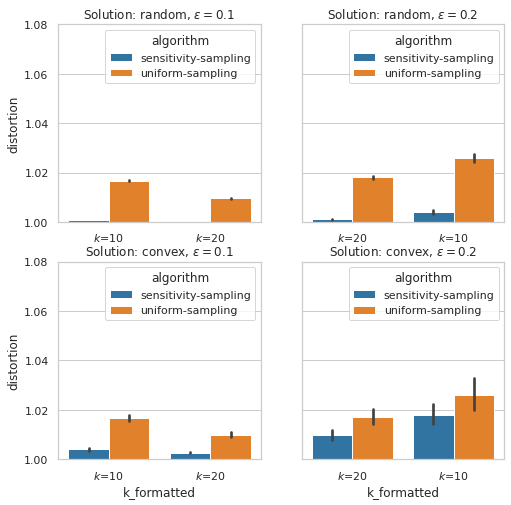

In [15]:
solution_types = df_raw_results["solution_type"].unique()
epsilons = df_raw_results["epsilon"].unique()
n_rows = len(solution_types)
n_cols = len(epsilons)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_rows*4, n_cols*4))

for i, solution_type in enumerate(solution_types):
    for j, epsilon in enumerate(epsilons):
        ax = axes[i,j]
        f1 = df_raw_results["solution_type"] == solution_type
        f2 = df_raw_results["epsilon"] == epsilon
        df_filtered = df_raw_results[f1&f2]
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion", hue="algorithm", ax=ax, palette=algorithm_colors)
        ax.set_ylim(bottom=1, top=1.08)
        ax.set_title(f"Solution: {solution_type}, $\\epsilon=${epsilon}")
        if j > 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
        if i == 0:
            ax.set_xlabel("")